# Forecasting Cryptocurrency Realized Volatility around FinTech Market Events

Here I compare the forecasting performance of using several different model types. Each model uses the same final two DNN layers with dropout. One of 128 units, and the final layer of 24 (the output horizon). Each of the models unique layers are:
1. A CNN with two layers of 1D convolutions with max pooling.
2. A LSTM with two LSTM layers.
3. A CNN stacked LSTM with layers from models 2 and 3 feeding into the common DNN layer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from model import squared_epsilon_insensitive_loss

2023-11-27 12:35:33.391899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/miniconda3/envs/fintech/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(col=None, path="./sentiment.csv"):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    return df

print("Multivariate Sample")
multivar_df = load_data(['date','logRet', 'sentiment_score'])
multivar_df.head()

Multivariate Sample


,date,logRet,sentiment_score
0,2023-02-25 20:45:00,0.001453,0.172491
1,2023-02-25 21:00:00,-0.000785,0.140640
2,2023-02-25 21:15:00,0.001055,0.093906
3,2023-02-25 21:30:00,-0.001289,0.133207
4,2023-02-25 21:45:00,0.001479,0.145924


# **Data Preprocessing**
We will use tf.datasets to prepare the data. The general strategy is to clean, scale, and split the data before creating the tf.dataset object. These steps can alternatively be done within the tf.dataset itself.

***Scaling data:*** In all cases the data is min max scaled.

***Features:*** As part of this simple analysis of models one feature set is prepared. A multivariate that contains log returns, sentiment scores, day of the week, hour and minute.

***Splitting data:*** 20% of test data (15-minute samples) is put aside to evaluate all the models. The train and validation sets are created with a 65/35 split.

In [3]:
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)


def make_time_features(series):
    
    #convert series to datetimes
    times = series.apply(lambda x: x.split('+')[0])
    datetimes = pd.DatetimeIndex(times)
    
    hours = datetimes.hour.values
    day = datetimes.dayofweek.values
    minutes = datetimes.minute.values
    
    hour = pd.Series(hours, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(minutes, name='minutes')
    
    return hour, dayofw, month


def split_data(series, train_fraq, test_len=200):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data

# Windowing the Dataset

Use tf.dataset to create a window dataset. This is a vector of past timesteps (n_steps) that is used to predict on a target vector of future steps (n_horizon). The example below shows the output for n_steps = 72 and n_horizon = 24 and the 5 features. So we use the last 18 hours (72 15-minute intervals) to predict the 6 hours (following 24 15-minute intervals). 

The resulting shape for X will be (batch size, n_steps, features) and Y will be (batch size, n_horizon, features).

In [4]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

# Dataset Loading Function

Wrap the above functions into a single function that allows us to build the dataset in the same way each time.

In [5]:
def build_dataset(train_fraq=0.65, 
                  n_steps=72, 
                  n_horizon=24, 
                  batch_size=256, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    if multi_var:
        data = load_data(col=['date', 'logRet', 'sentiment_score'])
        hours, day, minute = make_time_features(data.date)
        data = pd.concat([data.drop(['date'], axis=1), hours, day, minute], axis=1)
    else:
        data = load_data(col=['total load actual'])
        
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq, test_len=200)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = build_dataset(multi_var=True)

Prediction lookback (n_steps): 72
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


# Model Configurations

Define a set of model configurations so that we can call and run each model in the same way. The cgf_model_run dictionary will store the model, its history, and the test datasetset generated.

The default model parameters are:
- n_steps: last 30 days
- n_horizon: next 24 hours
- learning rate: 3e-4

In [6]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=72
    n_horizon=24
    if multivar:
        n_features=5
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)
    
    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

# Define Each Model

## CNN
Two Conv 1D layers with 64 filters each, and kernel sizes of 6 and 3 respectively. After each Conv1D layer a maxpooling1D layer with size of 2. 

In [27]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.Huber()
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 67, 64)            1984      
                                                                 
 max_pooling1d (MaxPooling1  (None, 33, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 15, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dropout (Dropout)           (None, 960)               0       

## LSTM
Two LSTM layers with 72 and 48 units each.

In [28]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 72)            22464     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096   

## CNN and LSTM Stacked
Using the same layers from the CNN and LSTM model, stack the CNN as input to the pair of LSTMs.

In [29]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 67, 64)            1984      
                                                                 
 max_pooling1d (MaxPooling1  (None, 33, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 15, 64)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 15, 72)            39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

# Train Models
Run each model for 150 epochs.

In [30]:
model_configs=dict()
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)

Prediction lookback (n_steps): 72
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
1/1 [==============================] - 1s 1s/step - loss: 0.2705 - mae: 0.6708 - val_loss: 0.1876 - val_mae: 0.5798
Epoch 2/150
1/1 [==============================] - 0s 45ms/step - loss: 0.2171 - mae: 0.5962 - val_loss: 0.1483 - val_mae: 0.5101
Epoch 3/150
1/1 [==============================] - 0s 43ms/step - loss: 0.1874 - mae: 0.5335 - val_loss: 0.1153 - val_mae: 0.4414
Epoch 4/150
1/1 [==============================] - 0s 44ms/step - loss: 0.1458 - mae: 0.4618 - val_loss: 0.0889 - val_mae: 0.3764
Epoch 5/150
1/1 [==============================] - 0s 44ms/step - loss: 0.1181 - mae: 0.4083 - val_loss: 0.0686 - val_mae: 0.3223
Epoch 6/150
1/1 [==============================] - 0s 42ms/step - loss: 0.0956 - mae: 0.3492 - val_loss: 0.0535 - val_mae: 0.278

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

# Evaluation of Training/Validation Results

Loss curves across the models are fairly stable. All models show a decreasing validation curve with different epoch thresholds for when the model stops learning against the validation set. The LSTM appears to begin to have the slowest learning curve, while the CNN takes around 20 epochs to reach a loss close to 0. Some options to help improve this are to introduce learning rate decline, or train on longer input sequences.

Plots of the MAE show a similar pattern to the loss plots.


Loss Curves


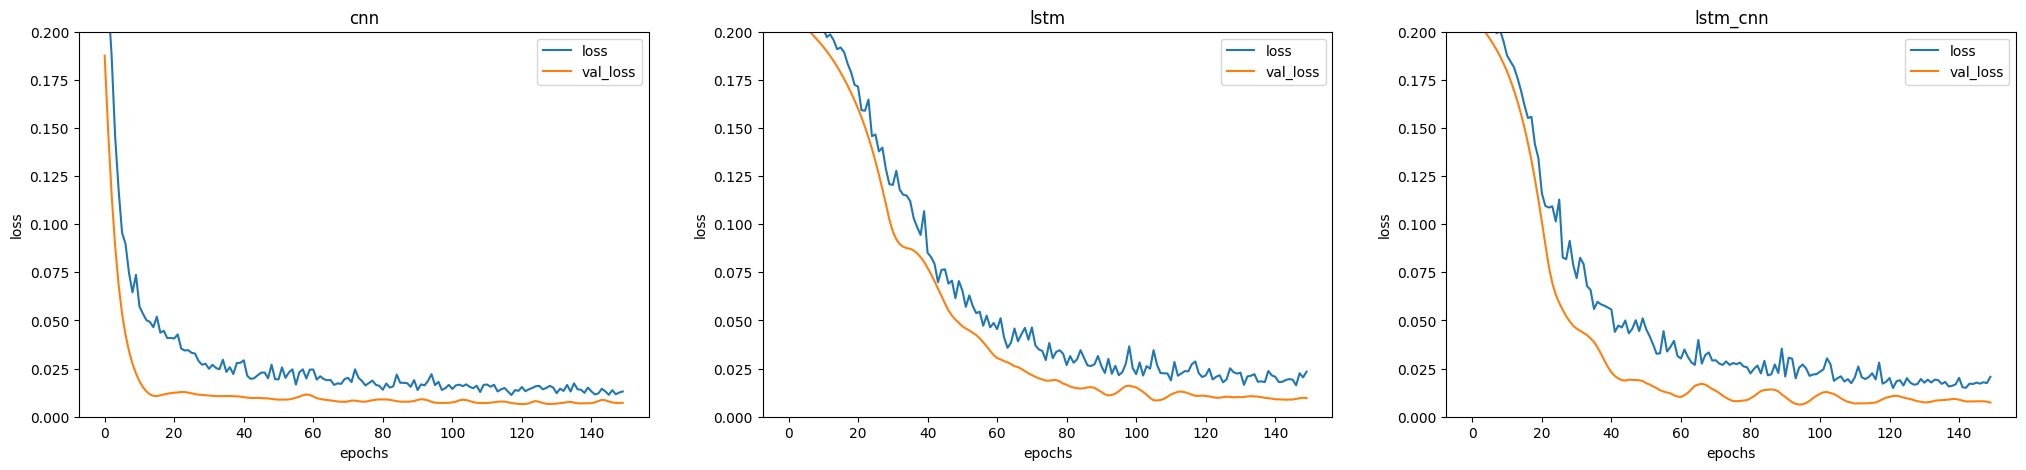

In [31]:
legend = list()

fig, axs = plt.subplots(1, 3, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


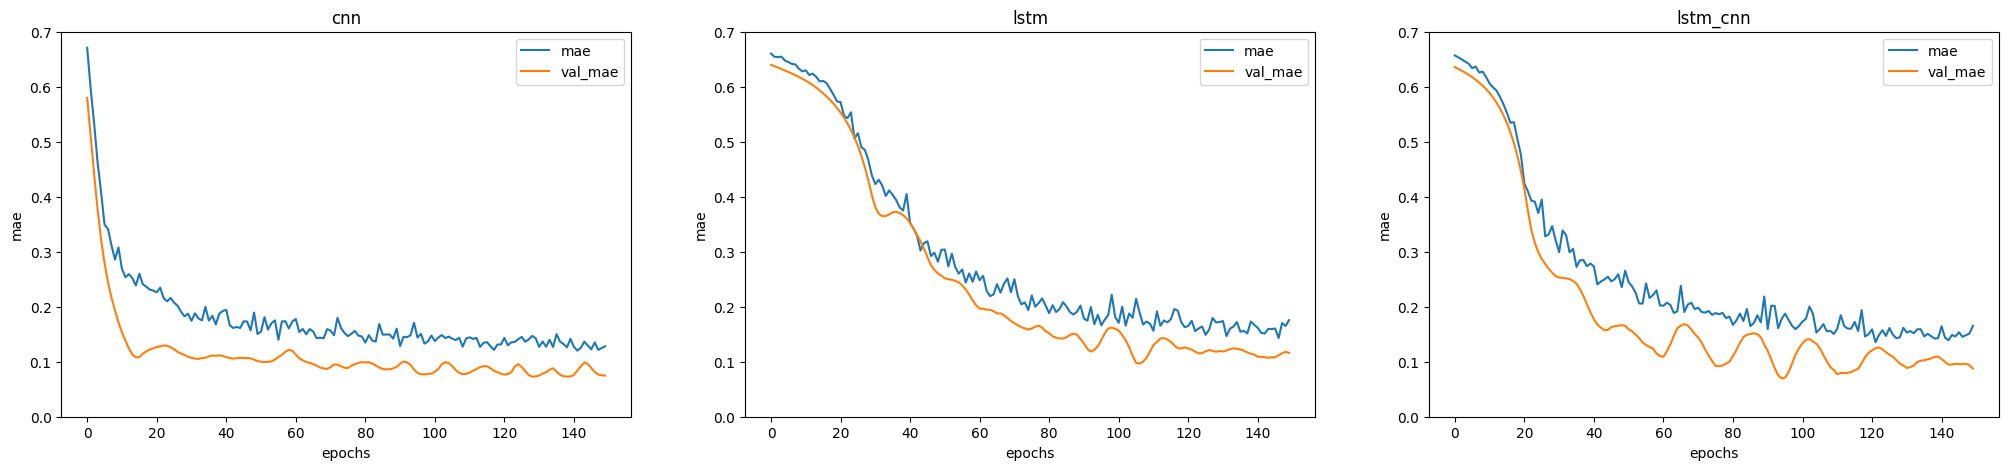

In [34]:
print("MAE Curves")
fig, axs = plt.subplots(1, 3, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.7)

# Evaluation of Test Results
It's surprising to see how well a CNN did. LSTM would be expected to perform well because of its ability to learn and remember longer trends in the data.

Putting the models' performance in perspective however the results show how with a limited lookback window, and simple features a lstm, and a cnn stacked with an lstm are a good starting choice for architecture.

In [35]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df

1/1 [==============================] - 0s 53ms/step - loss: 0.0048 - mae: 0.0907


,mae
cnn,0.054902
lstm,0.105826
lstm_cnn,0.090684


# Visualizing Predictions

Plot the actual and predicted 24 hour intervals. Below is the first 14 days of predictions. Interesting to note how the LSTM appears to oscilate over a longer frequency compared with the other models. The CNN also seems to capture the intra day oscillations (within the 24 hour period). Looking at the CNN stacked LSTM we can see how these two characteristics of the model's learning combine.

1/1 [==============================] - 0s 41ms/step


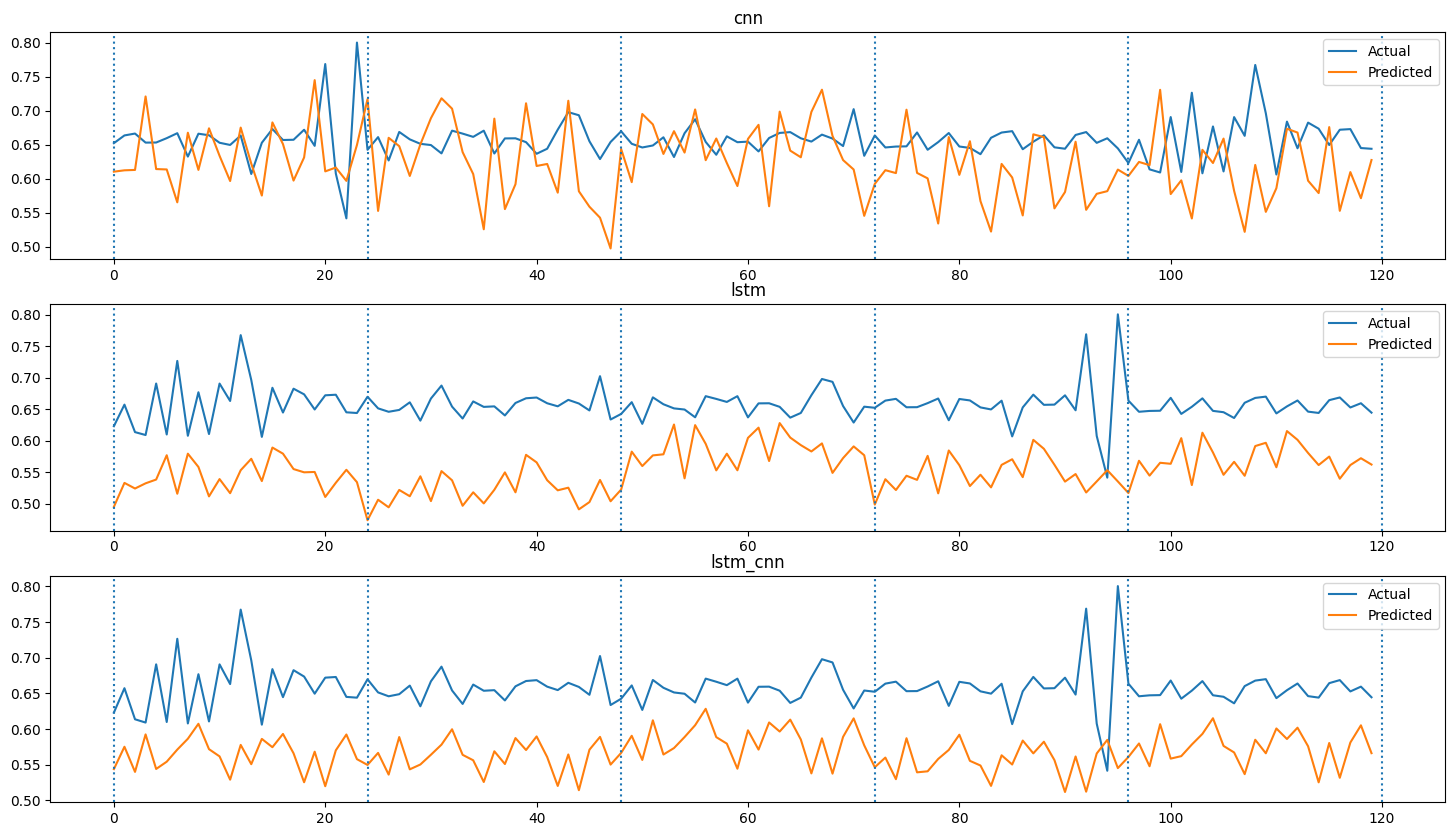

In [44]:
fig, axs = plt.subplots(3, 1, figsize=(18, 10))
days = 5

vline = np.linspace(0, days*24, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])